# Urban Heat Island effect in Fortaleza, Brazil

:::{eval-rst}
:opticon:`tag`
:badge:`urban-heat-island,badge-primary`
:badge:`ERA5-land,badge-secondary`
:::

[![RoHub - FAIR Executable Research Object](https://img.shields.io/badge/RoHub-FAIR_Executable_Research_Object-2ea44f?logo=Open+Access&logoColor=blue)](https://w3id.org/ro-id/21f214d9-214a-4abf-bd75-6e877a920276)

# Table of Contents
<ul>
<li><a href="#introduction">1. Introduction</a></li>
<li><a href="#data_wrangling">2. Data Wrangling</a></li>
<li><a href="#exploratory">3. Exploratory Data Analysis</a></li>
<li><a href="#conclusion">4. Conclusion</a></li>
<li><a href="#references">5. References</a></li>
</ul>

# 1. Introduction <a id='introduction'></a>
This work intends to demonstrate the occurrence of the urban heat island phenomenon over the city of Fortaleza (Brazil). We start with aggregating bibliography and other relevant documents/data ([ERA5-Land](https://www.ecmwf.int/en/era5-land)). We access ERA5-Land from the [RELIANCE datacube resources](https://reliance.adamplatform.eu/), by using the functionalities provided in the Adam API.

**Questions**
- Is it possible to quantify the existence of an Urban Heat Island Effect in Fortaleza (Brazil) with ERA5-Land?
- Is there any correlation with local measurements available?
- How has the situation changed over the last decades?

# 2. Data Wrangling <a id='data_wrangling'></a>

This study will compare 2 meter temperature from ERA5-Land from 3 different sites in the city of Fortaleza and its surroundings:

- MWS UFC: 3 44' 20'' S; 38 35' 37'' W
- AWS FOR 3 47' 42'' S; 38 33' 30'' W
- AWS SGA 3 39' 83'' S; 38 56' 32'' W

## Initialization
- Choose a country and add its name and country code
- Choose the variable to analyze (2M Temperature, etc.)
- Choose the area for your analysis

### Choose the country of interest

In [1]:
country_code = 'BR' 
country_fullname = "Brazil"
variable_name = '2M_TEMPERATURE'
variable_unit = 'K'
variable_long_name = '2m temperature'

### Geojson for selecting data
- The geometry field is extracted from a GeoJSON file, retrieving the value of the "feature" element.
- To create a geojson file for the area of interest, you can use https://geojson.io/
- Then paste the result below in the geojson variable

In [2]:
geojson = """{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -39,
              -4.48
            ],
            [
              -38,
              -4.48
            ],
            [
              -38,
              -3.39
            ],
            [
              -39,
              -3.39
            ],
            [
              -39,
              -4.48
            ]
          ]
        ]
      }
    }
  ]
}"""

## Organize my data

- Define a prefix for my project (you may need to adjust it for your own usage on your infrastructure).
    - input folder where all the data used as input to my Jupyter Notebook is stored (and eventually shared)
    - output folder where all the results to keep are stored
    - tool folder where all the tools, including this Jupyter Notebook will be copied for sharing
- Create all corresponding folders

In [3]:
import os
import pathlib

In [4]:
PREFIX_PATH =  os.getenv("HOME") + "/datahub/Reliance/"

In [5]:
WORKDIR_FOLDER = PREFIX_PATH + "UHI-ERA5-Land"
print("WORKDIR FOLDER: ", WORKDIR_FOLDER)

INPUT_DATA_DIR = os.path.join(WORKDIR_FOLDER, 'input')
OUTPUT_DATA_DIR = os.path.join(WORKDIR_FOLDER, 'output')
TOOL_DATA_DIR = os.path.join(WORKDIR_FOLDER, 'tool')

list_folders = [INPUT_DATA_DIR, OUTPUT_DATA_DIR, TOOL_DATA_DIR]

for folder in list_folders:
    pathlib.Path(folder).mkdir(parents=True, exist_ok=True)

WORKDIR FOLDER:  /home/jovyan/datahub/Reliance/UHI-ERA5-Land


### Geojson file for selecting data from ADAM
- We dissolve geojson in case we have more than one polygon and then save the results into a geojson file

In [6]:
import geopandas as gpd

In [7]:
local_path_geom = os.path.join(INPUT_DATA_DIR, country_code.lower() + '.geo.json')
local_path_geom

'/home/jovyan/datahub/Reliance/UHI-ERA5-Land/input/br.geo.json'

In [8]:
if (pathlib.Path(local_path_geom).exists()):
    os.remove(local_path_geom)
f = open(local_path_geom, "w")
f.write(geojson)
f.close()

In [9]:
data = gpd.read_file(local_path_geom)

In [10]:
single_shape = data.dissolve()

In [11]:
if (pathlib.Path(local_path_geom).exists()):
    os.remove(local_path_geom)

In [12]:
single_shape.to_file(local_path_geom, driver='GeoJSON')

## Import python packages

## Authentication to ADAM-Platform to get ERA5-Land 2 meter Temperature variable
Get the data requried for the analysis. The following lines of code will show the personal Adam API-Key of the user and the endpoint currently in use, that provide access to the products in the related catalogue. At the end of the execution, if the authentication process is successfull the personal token and the expiration time should be returned as outputs.

In [13]:
pip install adamapi

Note: you may need to restart the kernel to use updated packages.


### Get ADAM Key from a local file
- User would need to create this file to run the notebook.

In [14]:
adam_key = open(os.path.join(os.environ['HOME'],"adam-key")).read().rstrip()

In [15]:
import adamapi as adam
a = adam.Auth()
a.setKey(adam_key)
a.setAdamCore('https://reliance.adamplatform.eu')
a.authorize() 

{'expires_at': '2022-02-28T12:48:29.583Z',
 'access_token': '0602a77c216948f09105623c28db6875',
 'refresh_token': '9aa08c2019c042db82075b4ef18aa31e',
 'expires_in': 3600}

### Access to Product 
The products discovery operation related to a specific dataset is implemented in the Adam API with the <font color='blue'> **getProducts()** </font> function. A combined **spatial and temporal search** can be requested by specifying the <font color='red'> **datasetId** </font> for the selected dataset, the <font color='red'> **geometry** </font> argument that specifies the <u>Area Of Interest</u>, and a temporal range defined by `startDate` and `endDate` . The geometry must **<u>always</u>** be defined by a <font color='red'> **GeoJson object** </font> that describes the polygon in the **<u>counterclockwise winding order**</u>. The optional arguments `startIndex` and `maxRecords` can set the list of the results returned as an output. The results of the search are displayed with their metadata and they are sorted starting from the most recent product.

### Data Access

In [16]:
pip install geojson_rewind

Note: you may need to restart the kernel to use updated packages.


In [17]:
from geojson_rewind import rewind
import json

The GeoJson object needs to be rearranged according to the counterclockwise winding order. This operation is executed in the next few lines to obtain 
a geometry that meets the requirements of the method. **Geom_1** is the final result to be used in the discovery operation.

In [18]:
with open(local_path_geom) as f:
    geom_dict = json.load(f)
output = rewind(geom_dict)    
geom_1 = str(geom_dict['features'][0]['geometry'])

In [19]:
start_year = '2004'
end_year = '2006'

It is possible to access the data with the <font color='blue'> **getData** </font> function. Each product in the output list intersects the selected geometry and the following example shows how to access a specific product from the list of results obtained in the previous step. While the <font color='red'> **datasetId** </font> is always a mandatory parameter, for each data access request the <font color='blue'> **getData** </font> function needs only one of the following arguments: <font color='red'> **geometry** </font> or <font color='red'> **productId** </font>, that is the value of the <font color='blue'> **_id** </font> field in each product metadata. In the case of a <u>**spatial and temporal search**</u> the geometry must be provided to the function, together with the time range of interest. 
The output of the <font color='blue'> **getData** </font> function is <u>always</u> a <font color='red'> **.zip** </font> file containing the data retrieved with the data access request, providing the spatial **subset** of the product. The zip file will contain a geotiff file for each of the spatial subsets extracted in the selected time range.

#### Define a function to select a time range and get data

In [20]:
def getZipData(auth, dataset_info):
    if not (pathlib.Path(pathlib.Path(dataset_info['outputFname']).stem).exists() or pathlib.Path(dataset_info['outputFname']).exists()):
        data=adam.GetData(auth)
        image = data.getData(
        datasetId = dataset_info['datasetID'],
        startDate = dataset_info['startDate'],
        endDate = dataset_info['endDate'],
        geometry = dataset_info['geometry'],
        outputFname = dataset_info['outputFname'])
        print(image)

#### Get variable of interest for each day from start_date to end_date

This process can take a bit of time so be patient!

In [21]:
import time
from IPython.display import clear_output

In [22]:
datasetID = '90866:ERA5_LAND_DAILY_2M_TEMPERATURE'

In [24]:
start = time.time()

for year in ['2004', '2005', '2006']:
    datasetInfo = {
    'datasetID' : datasetID,
    'startDate' : year + '-02-01',
    'endDate' : year + '-05-31',
    'geometry' : geom_1,
    'outputFname' : INPUT_DATA_DIR + '/' + variable_name + '_' + country_code + '_ADAMAPI_' + year + '.zip'
    }
    getZipData(a, datasetInfo)
    
end = time.time()
clear_output(wait=True)
delta1 = end - start
print('\033[1m'+'Processing time: ' + str(round(delta1,2)))

Processing time: 160.73


### Data Analysis and Visualization of ERA5-Land 2 meter Temperature Dataset

#### Unzip data

In [26]:
import zipfile

In [27]:
def unzipData(filename, out_prefix):
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(path = os.path.join(out_prefix, pathlib.Path(filename).stem))

In [28]:
for year in ['2004', '2005', '2006']:
    filename = INPUT_DATA_DIR + '/' + variable_name + '_' + country_code + '_ADAMAPI_' + year + '.zip'
    target_file = pathlib.Path(os.path.join(INPUT_DATA_DIR, pathlib.Path(pathlib.Path(filename).stem)))
    if not target_file.exists():
        unzipData(filename, INPUT_DATA_DIR)

#### Read data and analyze

In [46]:
import pandas as pd
import xarray as xr
import glob

In [30]:
from datetime import datetime

In [31]:
def paths_to_datetimeindex(paths):
    return  [datetime.strptime(date.split('_')[-1].split('.')[0], '%Y-%m-%dt%f') for date in paths]

In [32]:
def getData(dirtif, variable):
    geotiff_list = glob.glob(dirtif)
    # Create variable used for time axis
    time_var = xr.Variable('time', paths_to_datetimeindex(geotiff_list))
    # Load in and concatenate all individual GeoTIFFs
    geotiffs_da = xr.concat([xr.open_rasterio(i, parse_coordinates=True) for i in geotiff_list],
                        dim=time_var)
    # Covert our xarray.DataArray into a xarray.Dataset
    geotiffs_da = geotiffs_da.to_dataset('band')
    # Rename the dimensions to make it CF-convention compliant
    geotiffs_da = geotiffs_da.rename_dims({'y': 'latitude', 'x':'longitude'})
    # Rename the variable to a more useful name
    geotiffs_da = geotiffs_da.rename_vars({1: variable, 'y':'latitude', 'x':'longitude'})

    return geotiffs_da

In [47]:
geotiff_ds = getData( INPUT_DATA_DIR + '/' + variable_name + '_'+ country_code + '_ADAMAPI_20*/*.tif', variable_name)
geotiff_ds[variable_name].attrs = {'units' : variable_unit, 'long_name' : variable_long_name }
geotiff_ds

<xarray.Dataset>
Dimensions:         (time: 361, latitude: 12, longitude: 11)
Coordinates:
  * latitude        (latitude) float64 -3.4 -3.5 -3.6 -3.7 ... -4.3 -4.4 -4.5
  * longitude       (longitude) float64 -39.0 -38.9 -38.8 ... -38.2 -38.1 -38.0
  * time            (time) datetime64[ns] 2006-05-31 2006-05-30 ... 2004-02-01
Data variables:
    2M_TEMPERATURE  (time, latitude, longitude) float32 300.5 nan ... 0.0 0.0
Attributes:
    transform:      (0.099999998304, 0.0, -39.04999939135999, 0.0, -0.0999999...
    crs:            +init=epsg:4326
    res:            (0.099999998304, 0.0999999986435015)
    is_tiled:       0
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [56]:
geotiff_ds.to_netcdf(OUTPUT_DATA_DIR + '/' + variable_name + '_'+ country_code + '_ADAMAPI.netcdf')

### Read dataset locally

In [58]:
geotiff_ds = xr.open_dataset(OUTPUT_DATA_DIR + '/' + variable_name + '_'+ country_code + '_ADAMAPI.netcdf')
geotiff_ds

<xarray.Dataset>
Dimensions:         (time: 361, latitude: 12, longitude: 11)
Coordinates:
  * latitude        (latitude) float64 -3.4 -3.5 -3.6 -3.7 ... -4.3 -4.4 -4.5
  * longitude       (longitude) float64 -39.0 -38.9 -38.8 ... -38.2 -38.1 -38.0
  * time            (time) datetime64[ns] 2006-05-31 2006-05-30 ... 2004-02-01
Data variables:
    2M_TEMPERATURE  (time, latitude, longitude) float32 ...
Attributes:
    transform:      [  0.1          0.         -39.04999939   0.          -0....
    crs:            +init=epsg:4326
    res:            [0.1 0.1]
    is_tiled:       0
    nodatavals:     0.0
    scales:         1.0
    offsets:        0.0
    AREA_OR_POINT:  Area

### Sites
- MWS UFC: 3 44' 20'' S; 38 35' 37'' W
- AWS FOR 3 47' 42'' S; 38 33' 30'' W
- AWS SGA 3 39' 83'' S; 38 56' 32'' W

In [66]:
aws_for = geotiff_ds.sel(latitude=-3.795, longitude=-38.5583, method='nearest')
aws_for

<xarray.Dataset>
Dimensions:         (time: 361)
Coordinates:
    latitude        float64 -3.8
    longitude       float64 -38.6
  * time            (time) datetime64[ns] 2006-05-31 2006-05-30 ... 2004-02-01
Data variables:
    2M_TEMPERATURE  (time) float32 299.9 299.9 299.0 298.7 ... 298.3 298.1 298.6
Attributes:
    transform:      [  0.1          0.         -39.04999939   0.          -0....
    crs:            +init=epsg:4326
    res:            [0.1 0.1]
    is_tiled:       0
    nodatavals:     0.0
    scales:         1.0
    offsets:        0.0
    AREA_OR_POINT:  Area

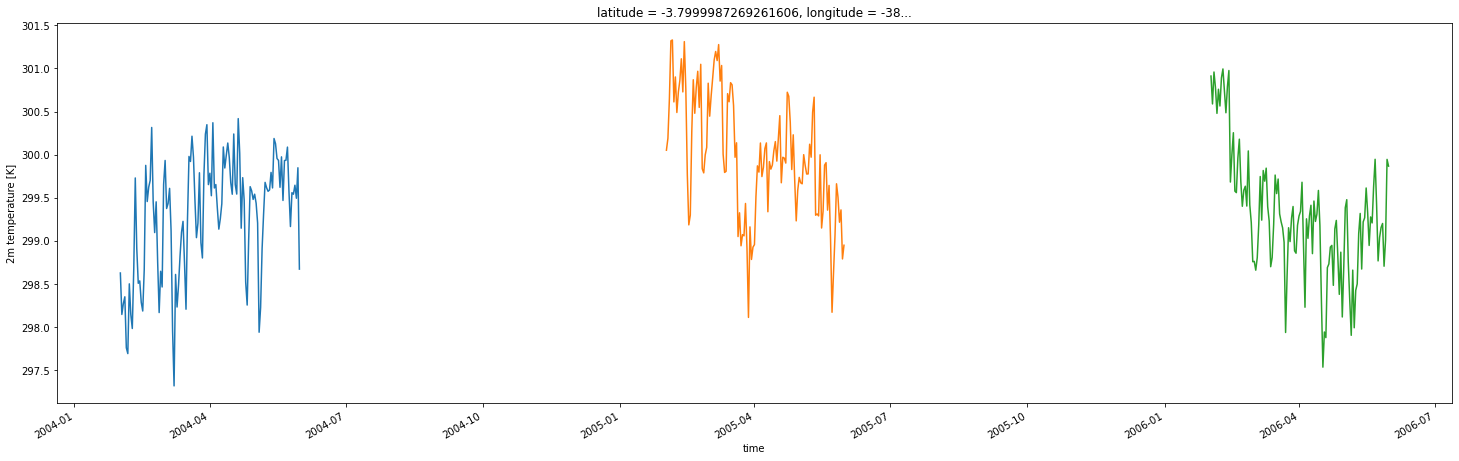

In [72]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(25,7))
for year in [2004, 2005, 2006]:
    aws_for['2M_TEMPERATURE'].sel(time=aws_for.time.dt.year.isin([year])).plot()